# Imports


In [112]:
import numpy as np
import os
import matplotlib.pyplot as plt

# Access functions

In [2]:
def retrieve_time(path):
    """
    Input: inner path to a result (path/job.out)
    Output: a float or an error
    """
    f = open(path + "/job.out", "r")
    return float(f.readlines()[1][6:])

In [83]:
def retrieve_settings(path):
    """
    Input: inner path to a result (path/job.out)
    Output: a numpy array of settings
    """
    options = path.split("/")
    settings = np.array([], dtype=np.float64)
    for set in options:
        if not str.isalpha(set.split("_")[-1]):
            settings = np.append(settings, np.float64(set.split("_")[-1]))
    return settings

In [103]:
def create_dataset(path, dataset):
    new_dataset = np.copy(dataset)
    if not os.path.isdir(path) or os.listdir(path) == []:
        return dataset
    elif "job.out" in os.listdir(path):
        try:
            time = retrieve_time(path)
            settings = retrieve_settings(path)
            row = np.append(settings, np.float64(time)).reshape(1, -1)
            return np.append(new_dataset, row, axis=0)
        except:
            return new_dataset
    else:
        for dir in os.listdir(path):
            new_dataset = create_dataset(path + "/" + dir, new_dataset)

    return new_dataset

## Tests


In [106]:
pthreads_times = create_dataset("results/logs/pthreads", np.array([0,0,0,0,0], dtype=np.float64).reshape(1, -1))

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [2.00000000e+00, 2.50000000e+01, 1.00000000e+01, 8.00000000e+00,
        1.79809571e+02],
       [2.00000000e+00, 2.50000000e+01, 1.00000000e+01, 4.00000000e+00,
        9.07972300e+01],
       [2.00000000e+00, 2.50000000e+01, 1.00000000e+01, 6.00000000e+00,
        1.90073903e+02],
       [2.00000000e+00, 1.00000000e+01, 1.00000000e+01, 8.00000000e+00,
        3.76900000e-03],
       [2.00000000e+00, 1.00000000e+01, 1.00000000e+01, 4.00000000e+00,
        6.37300000e-03],
       [2.00000000e+00, 1.00000000e+01, 1.00000000e+01, 6.00000000e+00,
        4.11600000e-03],
       [2.00000000e+00, 1.00000000e+01, 1.50000000e+01, 8.00000000e+00,
        1.02672000e-01],
       [2.00000000e+00, 1.00000000e+01, 1.50000000e+01, 4.00000000e+00,
        9.78500000e-02],
       [2.00000000e+00, 1.00000000e+01, 1.50000000e+01, 6.00000000e+00,
        1.25245000e-01],
       [8.00000000e+00, 2.5000

# Data retrieval


In [109]:
pthreads = create_dataset("results/logs/pthreads", np.array([0,0,0,0,0], dtype=np.float64).reshape(1, -1))[1:, :]
sequential = create_dataset("results/logs/sequential", np.array([0,0,0,0], dtype=np.float64).reshape(1, -1))[1:, :]

In [114]:
sequential

array([[2.50000000e+01, 1.00000000e+01, 8.00000000e+00, 2.63102921e+02],
       [2.50000000e+01, 1.00000000e+01, 4.00000000e+00, 1.59478442e+02],
       [2.50000000e+01, 1.00000000e+01, 6.00000000e+00, 2.64633320e+02],
       [1.00000000e+01, 1.00000000e+01, 8.00000000e+00, 6.56100000e-03],
       [1.00000000e+01, 1.00000000e+01, 4.00000000e+00, 6.30200000e-03],
       [1.00000000e+01, 1.00000000e+01, 6.00000000e+00, 7.94200000e-03],
       [1.00000000e+01, 1.50000000e+01, 8.00000000e+00, 2.14080000e-01],
       [1.00000000e+01, 1.50000000e+01, 4.00000000e+00, 2.00710000e-01],
       [1.00000000e+01, 1.50000000e+01, 6.00000000e+00, 2.51711000e-01]])

## Fixing indexes


In [196]:
sequential_idx = {"seq_length": 0, "patterns": 1, "mean_path_length": 2}
pthreads_idx = {"threads": 0, "seq_length": 1, "patterns": 2, "mean_path_length": 3}

## Possible values of each variable

In [234]:
def domain(dataset, variable):
    return np.unique(np.delete(dataset, variable, axis=1), axis=0)[:, :-1]

In [209]:
# Testing

domain(sequential, sequential_idx["patterns"])

array([[1.00000000e+01, 4.00000000e+00, 6.30200000e-03],
       [1.00000000e+01, 4.00000000e+00, 2.00710000e-01],
       [1.00000000e+01, 6.00000000e+00, 7.94200000e-03],
       [1.00000000e+01, 6.00000000e+00, 2.51711000e-01],
       [1.00000000e+01, 8.00000000e+00, 6.56100000e-03],
       [1.00000000e+01, 8.00000000e+00, 2.14080000e-01],
       [2.50000000e+01, 4.00000000e+00, 1.59478442e+02],
       [2.50000000e+01, 6.00000000e+00, 2.64633320e+02],
       [2.50000000e+01, 8.00000000e+00, 2.63102921e+02]])

# Plotting


In [267]:
def sequential_vs_pthreads(variable):
    x_sequential = []
    x_pthreads = []
    for const in domain(sequential, sequential_idx[variable]):
        values = np.copy(sequential)
        for i in range(sequential.shape[1] - 2):
            if i >= sequential_idx[variable]:
                values = values[(values[:, i+1] == const[i])]
            else:
                values = values[(values[:, i] == const[i])]
        x_sequential.append(values)

    for const in domain(pthreads, pthreads_idx[variable]):
        values = np.copy(pthreads)
        for i in range(1, pthreads.shape[1] - 2):
            if i >= pthreads_idx[variable]:
                values = values[(values[:, i+1] == const[i])]
            else:
                values = values[(values[:, i] == const[i])]
        x_pthreads.append(values)
            
    return x_sequential, x_pthreads

In [268]:
sequential_vs_pthreads("patterns")

([array([[1.0000e+01, 1.0000e+01, 4.0000e+00, 6.3020e-03],
         [1.0000e+01, 1.5000e+01, 4.0000e+00, 2.0071e-01]]),
  array([[1.0000e+01, 1.0000e+01, 4.0000e+00, 6.3020e-03],
         [1.0000e+01, 1.5000e+01, 4.0000e+00, 2.0071e-01]]),
  array([[1.00000e+01, 1.00000e+01, 6.00000e+00, 7.94200e-03],
         [1.00000e+01, 1.50000e+01, 6.00000e+00, 2.51711e-01]]),
  array([[1.00000e+01, 1.00000e+01, 6.00000e+00, 7.94200e-03],
         [1.00000e+01, 1.50000e+01, 6.00000e+00, 2.51711e-01]]),
  array([[1.0000e+01, 1.0000e+01, 8.0000e+00, 6.5610e-03],
         [1.0000e+01, 1.5000e+01, 8.0000e+00, 2.1408e-01]]),
  array([[1.0000e+01, 1.0000e+01, 8.0000e+00, 6.5610e-03],
         [1.0000e+01, 1.5000e+01, 8.0000e+00, 2.1408e-01]]),
  array([[ 25.      ,  10.      ,   4.      , 159.478442]]),
  array([[ 25.     ,  10.     ,   6.     , 264.63332]]),
  array([[ 25.      ,  10.      ,   8.      , 263.102921]])],
 [array([[2.0000e+00, 1.0000e+01, 1.0000e+01, 4.0000e+00, 6.3730e-03],
         [2.0

In [345]:
def plot_variable_sequential_pthreads(variable):
    # Grouping measurements by fixing all the other variables but the chosen one
    # Check sequntial_vs_pthreads for more info
    x_sequential, x_pthreads = sequential_vs_pthreads(variable)

    # Setting up the plots
    fig, axis = plt.subplots(len(x_sequential))

    # Fixing the interesting indexes
    seq_idx = sequential_idx[variable]
    pth_idx = pthreads_idx[variable]

    # Plotting each and every grouping
    for i, data in enumerate(zip(x_sequential, x_pthreads)):
        seq = data[0]
        pth = data[1]

        # Checking the groupings actually contain the same constants
        if np.equal(seq[0, :-1], pth[0, 1:-1]).all():            
            # Plotting the sequential datapoints for the chosen grouping
            axis[i].plot(seq[:, seq_idx], seq[:, -1], color='black', label = "Sequential")

            # Plotting the pthreads datapoints for the chosen grouping:
            # We need to group again on each thread number
            for j, colour in zip(set(pth[:, 0]), ("red", "blue", "yellow", "green")):
                pth_group = pth[pth[:, 0] == j]
                pth_label = str(int(pth_group[0, 0])) + " threads"

                axis[i].plot(pth_group[:, pth_idx], pth_group[:, -1], color=colour, label = pth_label)
            
        # Finsihing the plot
        title = ""
        for k in sequential_idx.keys():
                if k != variable:
                    title += k + "=" + str(2**seq[0, sequential_idx[k]]) + "\n"
        axis[i].set_title(title)
        axis[i].set_xlabel(variable)
        
    
    plt.yscale('log')
    plt.xscale('log', base=2)
    plt.grid(True)
    plt.legend()
    plt.ylabel('Time in seconds')
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_5507/1661151706.py:45: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


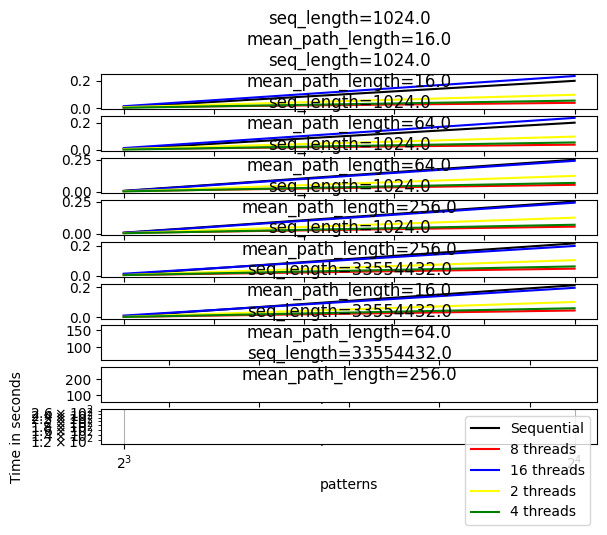

In [346]:
plot_variable_sequential_pthreads("patterns")

In [176]:
sequential[(sequential[:, 0] == 10) & (sequential[:, 2] == 4) & (sequential[:, 1] == 10)]


array([[1.000e+01, 1.000e+01, 4.000e+00, 6.302e-03]])

In [188]:
x_sequential = sequential[(sequential[:, 0] == 10) & 
               (sequential[:, 2] == 4)][:, 1]
y_sequential = sequential[(sequential[:, 0] == 10) & 
               (sequential[:, 2] == 4)][:, -1]
x_pthreads = pthreads[(pthreads[:, 0] == 2) & (pthreads[:, 1] == 10) & 
               (pthreads[:, 3] == 4)][:, 2]
y_pthreads = pthreads[(pthreads[:, 0] == 2) & (pthreads[:, 1] == 10) & 
               (pthreads[:, 3] == 4)][:, -1]
y_pthreads.shape

(2,)

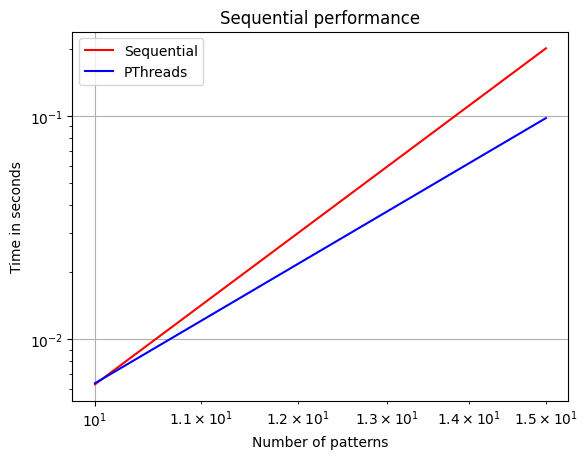

In [195]:
#plt.plot(x, y, linestyle = 'solid')
plt.plot(x_sequential, y_sequential, color='red', label = 'Sequential')
plt.plot(x_pthreads, y_pthreads, color='blue', label='PThreads')
plt.title('Sequential performance')
plt.xlabel('Number of patterns')
plt.ylabel('Time in seconds')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.grid(True)
plt.show()